<a href="https://colab.research.google.com/github/felipekbatista/microscopic_images/blob/master/code_versions/v1/image_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image treatment for use before feature extraction

This section here is dedicated to creating a treatment for the images before they can be used for feature exraction. 

The goal is to produce more normalized images for feature extraction

Some ideas:
- Histogram Equalization
    - general histogram equalization
    - CLAHE
- Sharpness 



# Imports

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage import io

In [39]:
pip install git+https://github.com/umang-singhal/pydom
from dom import DOM

  Cloning https://github.com/umang-singhal/pydom to /tmp/pip-req-build-dkfulkx8
  Running command git clone -q https://github.com/umang-singhal/pydom /tmp/pip-req-build-dkfulkx8
  Created wheel for pydom: filename=pydom-0.1-cp36-none-any.whl size=17989 sha256=d6531818bc253b58c96921f25ec02c521fb189c1472158166d330c8ab1fe8d6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-t0l0jrt0/wheels/ec/60/e5/1c67b8341ec0638e8d08d5163ca63d15a554a7eb7a0f684ad3
Successfully built pydom


In [44]:
path_das_imagens = '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01.jpg'
# for the access to the others imgs @ path_das_imagens use: m_01, m_02, m_03, m_04

# same for mask_path
mask_path = '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01_template.tiff'

# img read

In [82]:
img_list = []

for i in range(1,5):
    img = io.imread('/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_0{}.jpg'.format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_list.append(img)
    print('img read and appended')




img read and appended
img read and appended
img read and appended
img read and appended


# Histogram 

Histogram visualization of the imgs

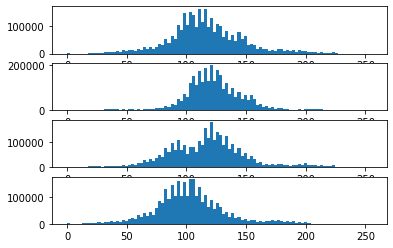

In [61]:
fig, axs = plt.subplots(nrows=4)
for i in range(4):
    img = img_list[i]
    axs[i].hist(img.flatten(), range = (0,255), bins = 100)
    #axs[i].title('img {}'.format(str(i)))
    

The histograms show a good distributiion, so my guess is that a regular Histogram Equalization might be enough to boost the quality of th image.

For measuring the quality of the image an algorith will be used, DOM

---

In [83]:
iqa = DOM()

for i in range(len(img_list)):
    img_ = img_list[i]
    print('score:', iqa.get_sharpness(img_))


score: 1.0249254649991768
score: 1.0239146633097915
score: 1.0345651005242658
score: 0.9904316762449078


## Normal histogram Equalization

In [29]:
from skimage import img_as_float, exposure, img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank

In [154]:
def histogram_equalization(image):
    'input: original img'
    'returns: img_as_float, img_rescale, img_eq, img_adapteq'
    img_float = image
    #img_float = img_as_float(image)
    # Contrast stretching
    p2, p98 = np.percentile(img_float, (2, 98), )
    img_rescale = exposure.rescale_intensity(img_float, in_range=(p2, p98))
    img_rescale = _rescale(img_rescale)
    # Equalization
    img_eq = exposure.equalize_hist(img_float)
    img_eq = _rescale(img_rescale)
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img_float, clip_limit=0.03)
    img_adapteq = _rescale(img_rescale)
    return img_float, img_rescale, img_eq, img_adapteq 

def _rescale(img):
    'use this for rescaling some images that are float'
    a,b = img.shape[0], img.shape[1]
    img = img.reshape(-1)
    max_, min_ = max(img), min(img)
    
    for i in range(len(img)):
        numm = img[i]/(max_-min_) * 255
        img[i] = numm
    img = np.uint8(img)
    img = img.reshape(a,b)
      
    return img


def plot_img_and_histograms(img, img_rescale, img_eq, img_adapteq):
    'plot the images from the histogram equalization function'
    'input: img, img_rescale, img_eq, img_adapteq'
    fig, axs = plt.subplots(nrows = 4, ncols = 2,figsize=(10,20))
    axs[0,0].imshow(img)
    axs[0,1].hist(img.flatten(),bins = 100)
    axs[1,0].imshow(img_rescale)
    axs[1,1].hist(img_rescale.flatten(),bins = 100)
    axs[2,0].imshow(img_eq)
    axs[2,1].hist(img_eq.flatten(),bins = 100)
    axs[3,0].imshow(img_adapteq)
    axs[3,1].hist(img_adapteq.flatten(), bins = 100)
    return 

def CLAHE(image):
    # Load an example image
    img = image
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = img_as_ubyte(img)
    # Global equalize
    img_rescale = exposure.equalize_hist(img)
    # Equalization
    selem = disk(30)
    img_eq = rank.equalize(img, selem=selem)
    img_rescale = _rescale(img_rescale)
    img_eq = _rescale(img_eq)
    return img_rescale, img_eq

def get_quality_dom(img_):
    iqa = DOM()
    'returns the sharpness score of the image and its equalization'
    img_1, img_2, img_3, img_4 = histogram_equalization(img_)
    img_5, img_6 = CLAHE(img_)
    print('original_score:', iqa.get_sharpness(img_1).round(8))
    print('standart histogram')
    print('contrast stretching:',iqa.get_sharpness(img_2).round(8))
    print('equalization',iqa.get_sharpness(img_3).round(8))
    print('adaptative equalization',iqa.get_sharpness(img_4).round(8))
    print('CLAHE')
    print('equalize hist', iqa.get_sharpness(img_5))
    print('equalize', iqa.get_sharpness(img_6))
    print('end function\n')
    return 



In [135]:
img = img_list[0]
#img_1, img_2, img_3, img_4 = histogram_equalization(img)


In [155]:
for i in img_list:
    get_quality_dom(i)
    print('\n')



original_score: 1.02492546
standart histogram
contrast stretching: 1.03178031
equalization 1.03178031
adaptative equalization 1.03178031
CLAHE
equalize hist 1.0286334541542692
equalize 1.1059413285084616
end function



original_score: 1.02391466
standart histogram
contrast stretching: 1.02657745
equalization 1.02657745
adaptative equalization 1.02657745
CLAHE
equalize hist 1.0300333765040177
equalize 1.0776997453791446
end function



original_score: 1.0345651
standart histogram
contrast stretching: 1.04380376
equalization 1.04380376
adaptative equalization 1.04380376
CLAHE
equalize hist 1.0421164617368575
equalize 1.1211899458148027
end function



original_score: 0.99043168
standart histogram
contrast stretching: 0.99337299
equalization 0.99337299
adaptative equalization 0.99337299
CLAHE
equalize hist 0.9999860042509574
equalize 1.0562453706880197
end function





/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


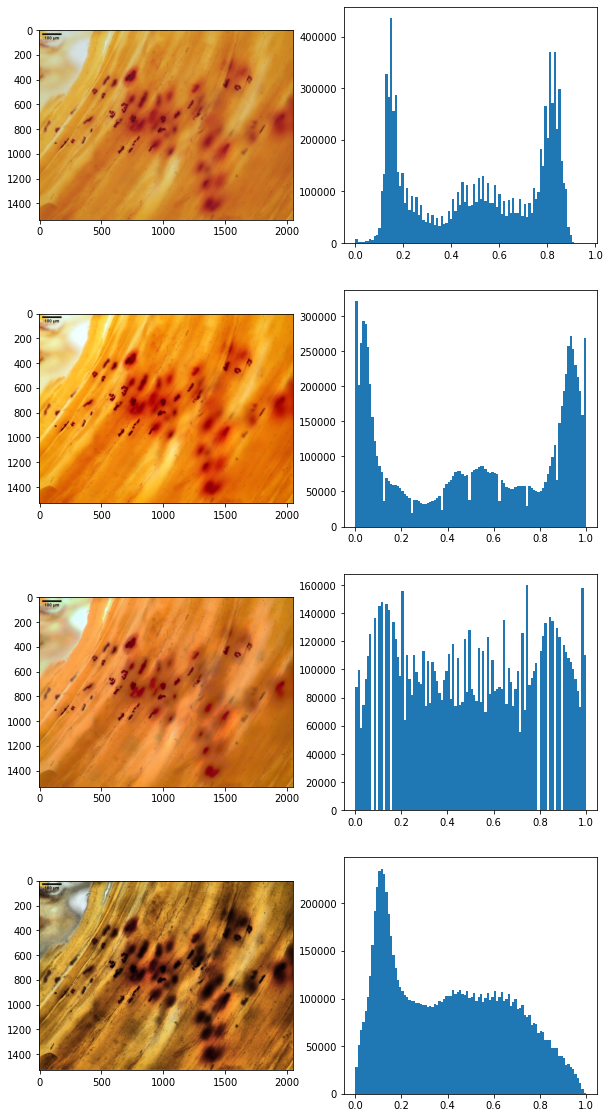

In [52]:
    img_1, img_2, img_3, img_4 = histogram_equalization(img)
plot_img_and_histograms()

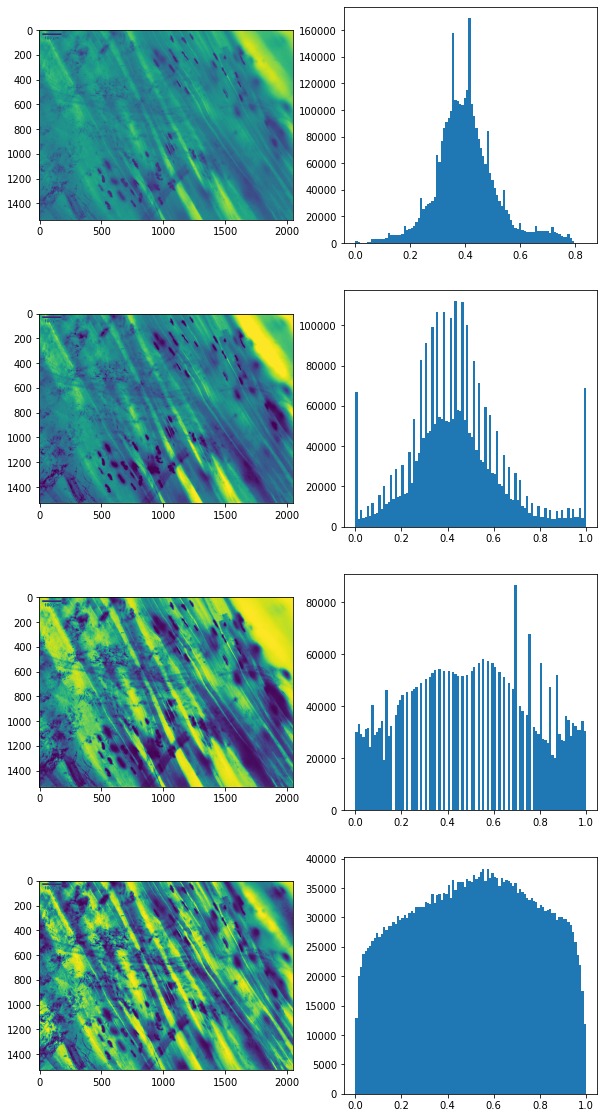

In [64]:
img_1, img_2, img_3, img_4 = histogram_equalization(img)
plot_img_and_histograms(img_1, img_2, img_3, img_4 )

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


(array([ 28541.,  51418.,  67297.,  75509.,  87046., 101810., 124049.,
        156192., 191662., 217323., 233791., 236202., 230389., 211945.,
        188925., 165187., 145143., 131542., 119549., 112433., 107744.,
        103820., 101222.,  98301.,  97678.,  97248.,  94784.,  95643.,
         94251.,  93216.,  93045.,  91226.,  92538.,  91123.,  94269.,
         93451.,  97819.,  96607.,  99274., 102282., 102279., 102591.,
        108636., 104418., 106572., 109207., 104505., 103382., 108276.,
        100204., 101403., 105917.,  97090., 101608., 104849.,  96506.,
        100443., 105883.,  97984., 101824., 107599.,  97806., 101847.,
        106843.,  97012.,  99902., 104218.,  92563.,  96241.,  99679.,
         89368.,  89659.,  93245.,  82530.,  80701.,  82294.,  71831.,
         74450.,  73034.,  64231.,  65474.,  65004.,  56330.,  56895.,
         56612.,  48145.,  48284.,  47880.,  39851.,  39486.,  38076.,
         30403.,  30803.,  27684.,  26005.,  21161.,  17048.,  11235.,
      

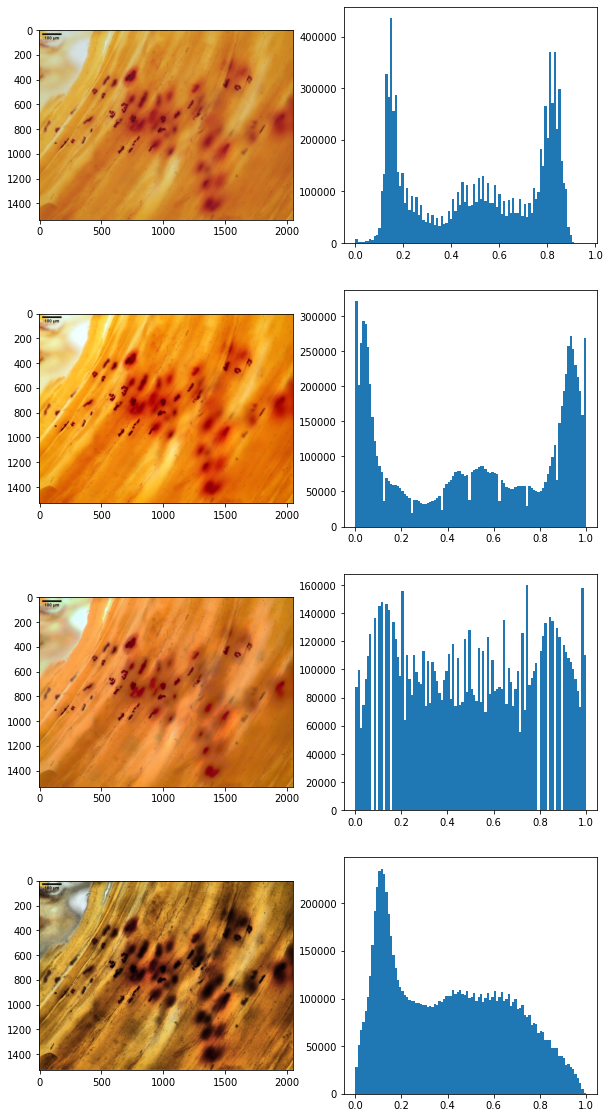

In [23]:
# Load an example image
img = img_list[0]
img = img_as_float(img)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98), )
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

fig, axs = plt.subplots(nrows = 4, ncols = 2,figsize=(10,20))
axs[0,0].imshow(img)
axs[0,1].hist(img.flatten(),bins = 100)
axs[1,0].imshow(img_rescale)
axs[1,1].hist(img_rescale.flatten(),bins = 100)
axs[2,0].imshow(img_eq)
axs[2,1].hist(img_eq.flatten(),bins = 100)
axs[3,0].imshow(img_adapteq)
axs[3,1].hist(img_adapteq.flatten(), bins = 100)

## Quality of image - DOM

## CLAHE

In [ ]:
import dom

(array([11106., 11519.,  8071., 12346.,  8557., 13657.,  9119., 13715.,
         9454., 15167., 15410., 10875., 17310., 11170., 18072., 12014.,
        18668., 12509., 20457., 13773., 21574., 22690., 16034., 24406.,
        17691., 26079., 17886., 28076., 19180., 30071., 32693., 22036.,
        34297., 23783., 37370., 25689., 40209., 29231., 44214., 30871.,
        49019., 52144., 37137., 60732., 41481., 66676., 47030., 75255.,
        52418., 84860., 84652., 56282., 82934., 53788., 77590., 49748.,
        73096., 45312., 65481., 41123., 58471., 55656., 36614., 50565.,
        32739., 47014., 30266., 44265., 29505., 40870., 39737., 25639.,
        37335., 24151., 36434., 23228., 33813., 22119., 32218., 20546.,
        30557., 30212., 19259., 28466., 17909., 26076., 17304., 26374.,
        16683., 23776., 22454., 15157., 21961., 15683., 22209., 13620.,
        19319., 13417., 18348., 13760.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

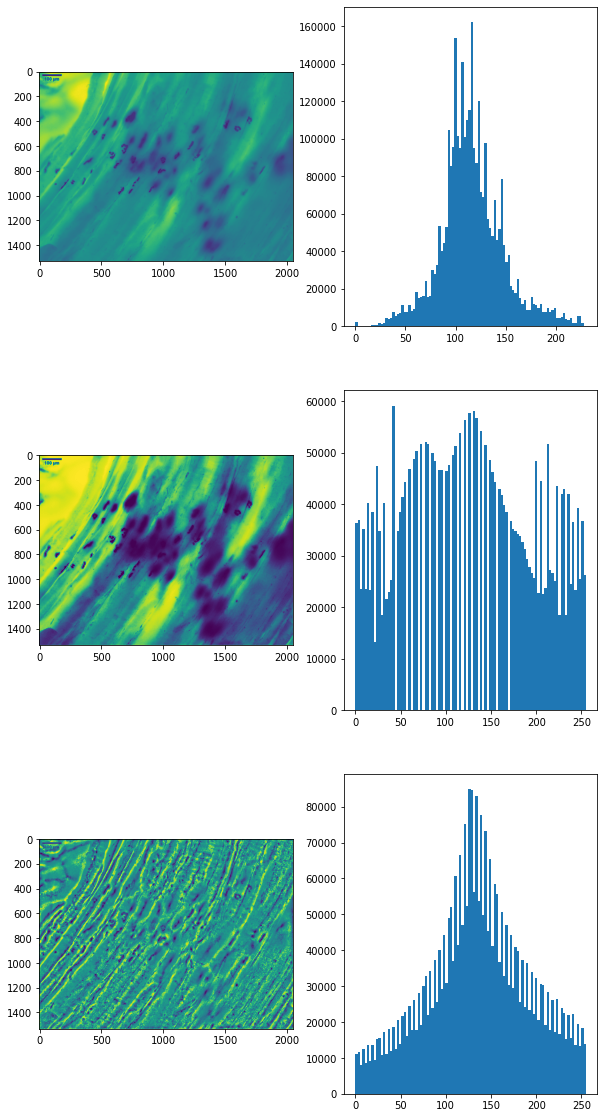

In [157]:
#img_1, img_2 = CLAHE(img_list[0])

fig, axs = plt.subplots(nrows = 3, ncols = 2,figsize=(10,20))
axs[0,0].imshow(img_list[0], )
axs[0,1].hist(img_list[0].flatten(),bins = 100)
axs[1,0].imshow(img_1,)
axs[1,1].hist(img_1.flatten(),bins = 100)
axs[2,0].imshow(img_2,)
axs[2,1].hist(img_2.flatten(),bins = 100)

# RESULTS

The sharpness algorithm shows some improvement for standard histogram equalization but shows some great improvement for CLAHE methods.

With this in mind it can be said that this is a first version of treatment for the img before feature extraction